This program can identify the domains from a PDB structure, it needs a .pdb file of the structure and a .txt of the protein from UNIPROT

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

#seq = []
#upper_fragment = 0
#lower_fragment = 0
#nres = 0

def contacts_intradomain(p, q,contact_matrix):
    # definition comes here for a domain starting at postion p and ending at position q.
    # The concats in the corresponding upper triangle matrix should be counted and returned.
    intradomain = 0
    for i in range(p,q):
        for j in range(p+1,q):
            intradomain+=contact_matrix[i][j]
    return intradomain

    
def contacts_interdomain(p1, p2, q1, q2,contact_matrix):
    interdomain = 0
    # definition comes here. Contacts should be counted in a rectangular area where
    # domain A starts at p1 and ends at q1 and domain B from p2 to q2.
    for i in range(p1,p2):
        for j in range(q1,q2):
            interdomain+=contact_matrix[i][j]
    return interdomain

def PDB_parser(file_name):
    seq = []
    upper_fragment = 0
    lower_fragment = 0
    # storing coordinates in arrays ranging from 0 to
    # the number of residues
    coordx = []
    coordy = []
    coordz = []
    # residue numbers will also be stored as numbering in PDB files
    # rarely starts with 1, residues can be missing etc.
    pdb_resnum = []
    # cutoff value for CA-CA distances
    cutoff = 8
    # number of residues that have been read in
    nres = 0
    # defining the name of the file. Should be in the same folder as the program/notebook.
    pdbfile = open (file_name)
    for line in pdbfile:
        #finding the uniprotnumbering
        if line.startswith("DBREF") and line[12]=="A":
            lower_fragment = int(line.split()[-2])
            upper_fragment = int(line.split()[-1])
        # only ATOM lines will be considered
        if line.startswith("ATOM"):
            # obtaining the atom name and getting rid of spaces
            atom=line[12:15].replace(" ","")
            # the chain identifier is 1 character
            chain=line[21:22]
            # processing only lines of CA atoms in chain A
            if atom == "CA" and chain == "A":
                #obtaining the residue
                res = line[17:20]
                seq.append(res)
                # the append function adds a value to the array. The substring at given positions of the line
                # should be converted to a floating-point number.
                coordx.append(float(line[30:37]))
                coordy.append(float(line[38:45]))
                coordz.append(float(line[46:53]))
                # storing residue numbers, they are integers 
                pdb_resnum.append(int(line[22:27]))
                # we have appended a value to each array, they should have equal size and the data
                # for the same residue should be accessible at the same index that corresponds to nres 
                # (the first index is zero and we set nres to zero above). Now we increase nres to keep track.
                nres=nres+1
    # Initialization: filling the contact matrix with zeroes
    contact_matrix = [[0 for h in range(nres)] for k in range(nres)]

    # Building the contact_matrix
    for i in range(nres):
        for j  in range(nres):
            dis = np.sqrt(np.square(coordx[i]-coordx[j])+np.square(coordy[i]-coordy[j])+np.square(coordz[i]-coordz[j]))
            if dis < cutoff:
                contact_matrix[i][j]=1
    plt.figure(figsize=(10,10))
    plt.imshow(contact_matrix, cmap = "Blues")
    plt.show()
    return contact_matrix, seq, nres, lower_fragment, upper_fragment


def domak_calculater(contact_matrix, nres):
    # Claculate the DOMAK for every residue, and plotting it
    residue=[]
    domak=[]
    for i in range(1,nres):
        intA = contacts_intradomain(0,i,contact_matrix)
        intB = contacts_intradomain(i,nres,contact_matrix)
        extAB = contacts_interdomain(0,i,i+1,nres,contact_matrix)
        if extAB == 0:
            extAB = 1
        e = (intA*intB)/(extAB**2)
        residue.append(i)
        domak.append(e)
        
    # Plotting the curve (DOMAK/Residue)    
    plt.figure(figsize=(20,6))    
    plt.plot(residue, domak)
    plt.xlabel('residue')
    plt.ylabel('DOMAK')
    plt.grid()
    plt.title('Domains')
    plt.show()
    return residue, domak
    
    
def peak_finder(residue, domak):
    # Finds peaks in the plot
    max_y = max(domak[10: -10])
    peaks, _ = find_peaks(domak[0: -10], prominence = max_y/4, distance = 10)
    print("peaks: " + str(peaks))
    return peaks

def uniprot_parser(txt_file_name, lower_fragment, upper_fragment):
    # Gets the domains info from UNIPROT .txt file
    txtfile = open (txt_file_name)
    domains = []
    for line in txtfile:
        # only ATOM lines will be considered
        if line.startswith("FT"):
            if line[5:11] == "DOMAIN":
                prep = line.split()
                domain = prep[-1].split('..')
                if int(domain[1]) > lower_fragment and int(domain[0]) < upper_fragment:
                    #print(domain)
                    domains.append(domain)
    return domains

def domain_aligner(peaks, domains, nres, lower_fragment):
    # The domains might be numbered differently; this function aligns the domains into one sequences
    domains_calc = []
    # The ones calculated by the program (from the peaks)
    lower = 0
    for p in peaks:
        domain = range(lower,p)
        lower = p
        domains_calc.append(domain)
    last_domain = range(peaks[-1],nres)
    domains_calc.append(last_domain)
    
    domains_r = []
    # The ones parsed from the UNIPROT .txt file
    for d in domains:
        lower = int(d[0])-lower_fragment
        upper = int(d[1])-lower_fragment
        if lower < 0:
            lower = 0
        if upper > nres:
            upper = nres
        domain = range(lower, upper)
        domains_r.append(domain)
    
    return domains_calc, domains_r

def domains_plotter(domains_r, domains_calc):
    # Plots the domains
    colors1 =['purple', 'blue', 'cyan', 'green', 'yellow', 'orange', 'red']
    colors2 = ['purple', 'blue', 'cyan', 'green', 'yellow', 'orange', 'red']
    if len(colors1) > len(domains_r) and len(colors2) > len(domains_calc):
        colors1 = colors1[0:len(domains_r)]
        colors2 = colors2[0:len(domains_calc)]
    else:
        colors1 = "Blue"
        colors2 = "Blue"
    fig=plt.figure()
    plt.figure(figsize=(20,6))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212, sharex = ax1)
    ax1.eventplot(domains_r, linelengths = 0.2, lineoffsets = 0.05, colors = colors1)
    ax2.eventplot(domains_calc, linelengths = 0.2, lineoffsets = 0.05, colors = colors2)
    ax1.grid()
    ax2.grid()
    ax1.title.set_text('Uniprot')
    ax2.title.set_text('program')
    plt.show()

def main_program(file_name, txt_file_name):
    # Runs the whole thing
    contact_matrix, seq, nres, lower_fragment, upper_fragment = PDB_parser(file_name)
    residue, domak = domak_calculater(contact_matrix, nres)
    peaks = peak_finder(residue, domak)
    domains = uniprot_parser(txt_file_name, lower_fragment, upper_fragment)
    domains_calc, domains_r = domain_aligner(peaks, domains, nres, lower_fragment)
    domains_plotter(domains_r, domains_calc)
    print("domains from UNIPROT: " + str(domains_r))
    print("domains calculated by the program: " + str(domains_calc))


User interface:

name of the .pdb file: 
1gpz.pdb
name of the .txt file: 
p00736.txt


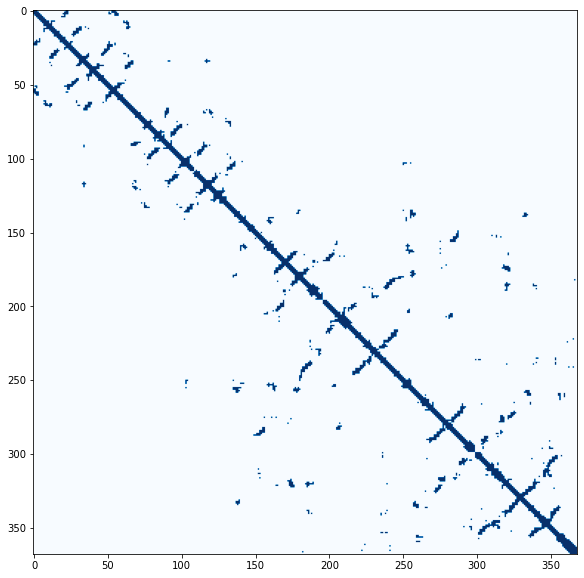

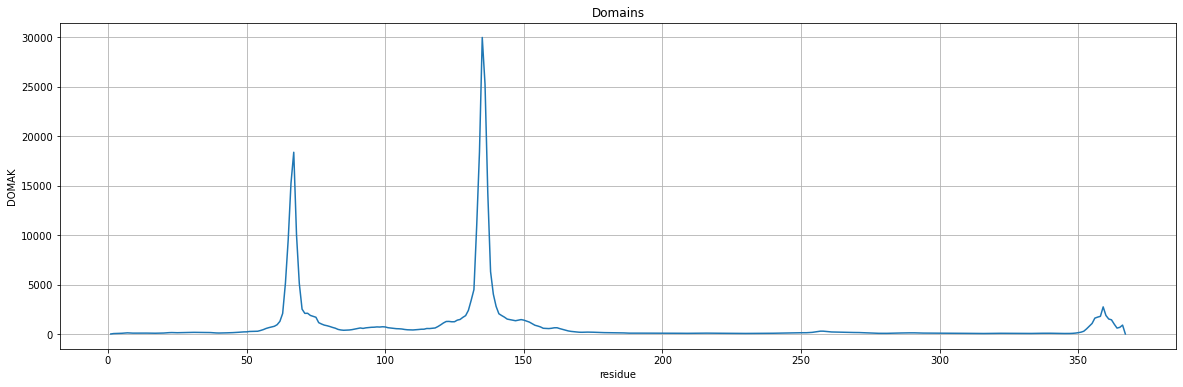

peaks: [ 66 134]


<Figure size 432x288 with 0 Axes>

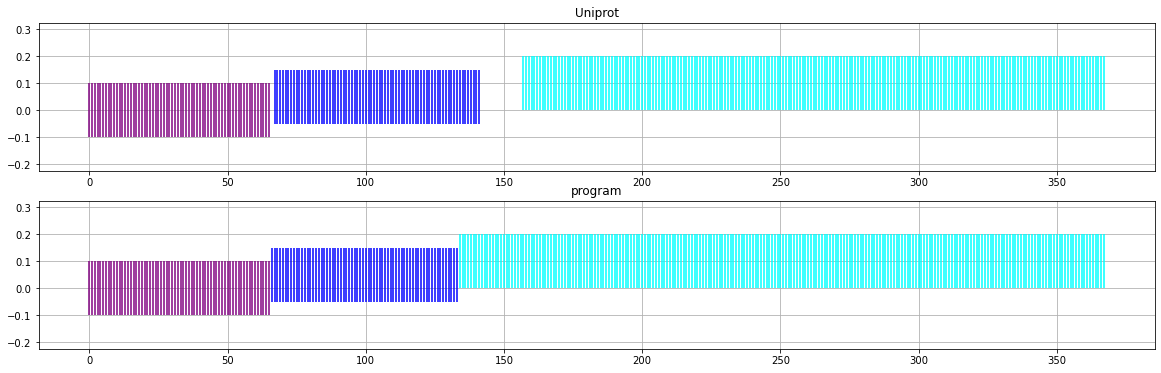

domains from UNIPROT: [range(0, 66), range(67, 142), range(157, 368)]
domains calculated by the program: [range(0, 66), range(66, 134), range(134, 368)]


In [3]:
pdb_file = input("name of the .pdb file: \n")
txt_file = input("name of the .txt file: \n")
try:
    main_program(pdb_file, txt_file)
except FileNotFoundError:
    print("The requested .PDB file or the .txt file is not found\nPleae make sure to copy the files to the same directory of the program")
    

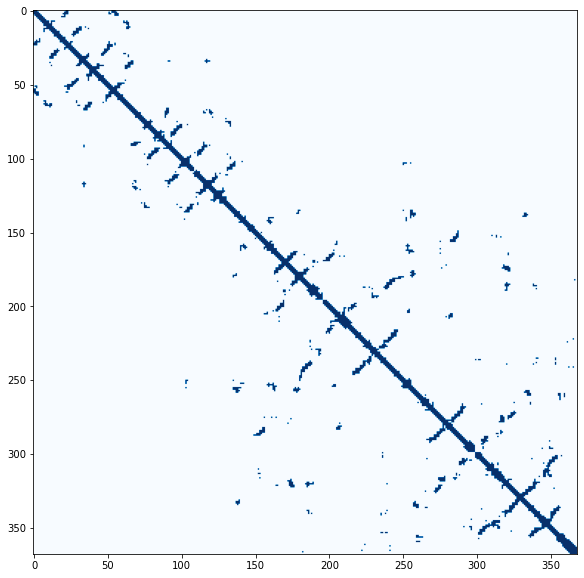

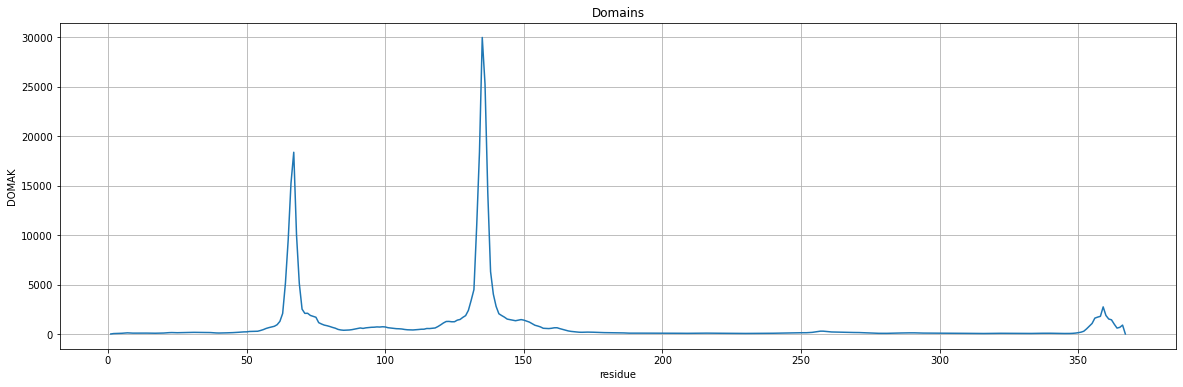

peaks: [ 66 134]


<Figure size 432x288 with 0 Axes>

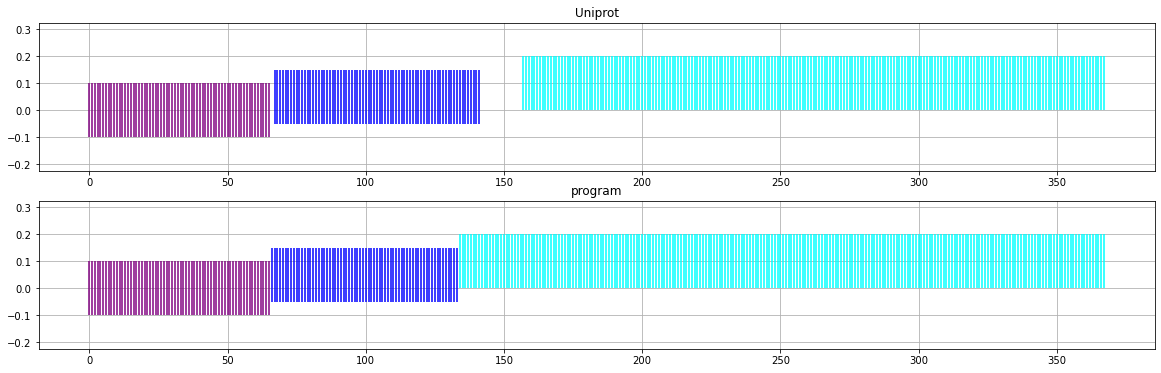

domains from UNIPROT: [range(0, 66), range(67, 142), range(157, 368)]
domains calculated by the program: [range(0, 66), range(66, 134), range(134, 368)]


In [4]:
main_program("1gpz.pdb", "P00736.txt")

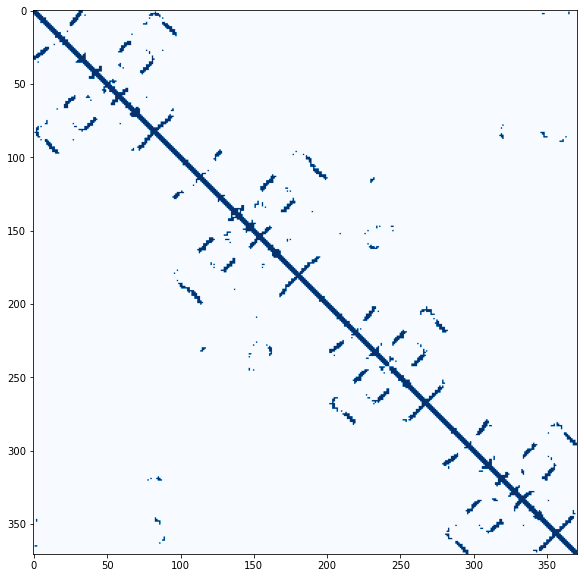

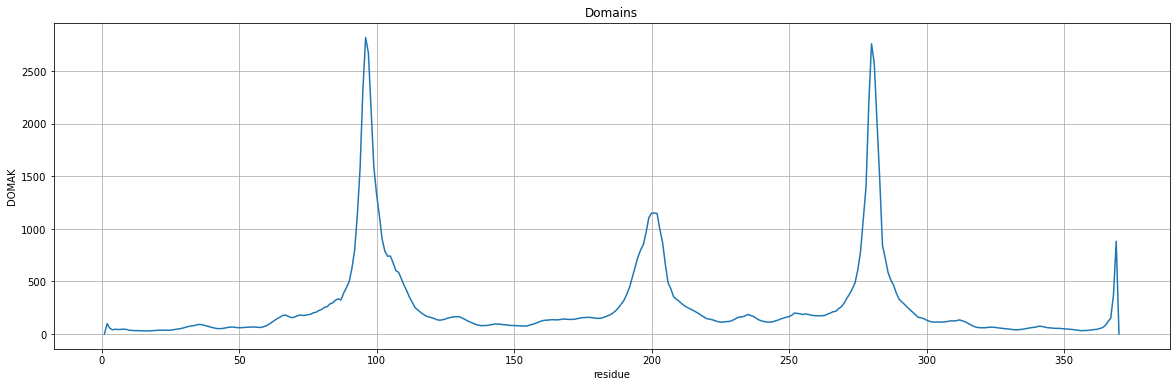

peaks: [ 95 200 279]


<Figure size 432x288 with 0 Axes>

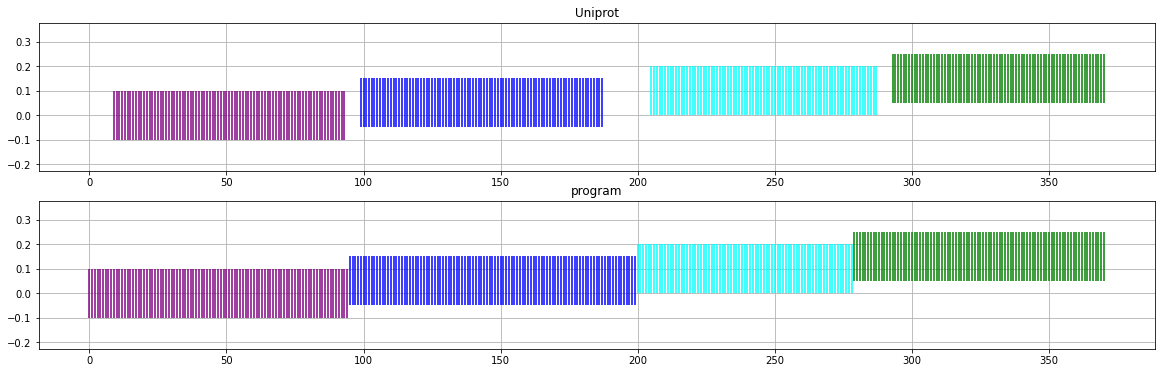

domains from UNIPROT: [range(9, 94), range(99, 188), range(205, 288), range(293, 371)]
domains calculated by the program: [range(0, 95), range(95, 200), range(200, 279), range(279, 371)]


In [5]:
main_program("2OM5.pdb", "Q02246.txt")

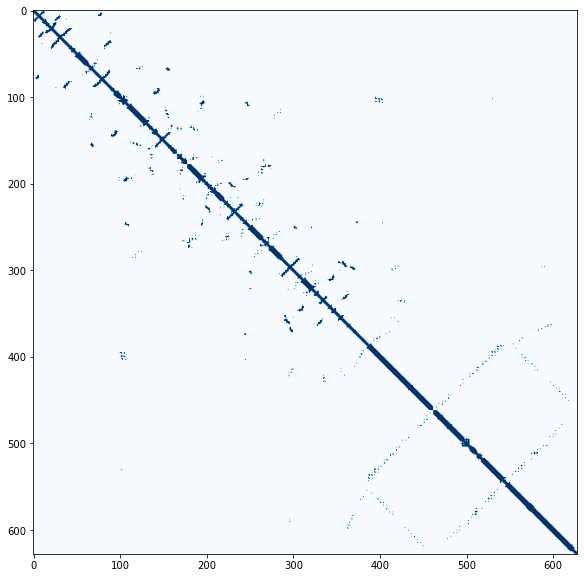

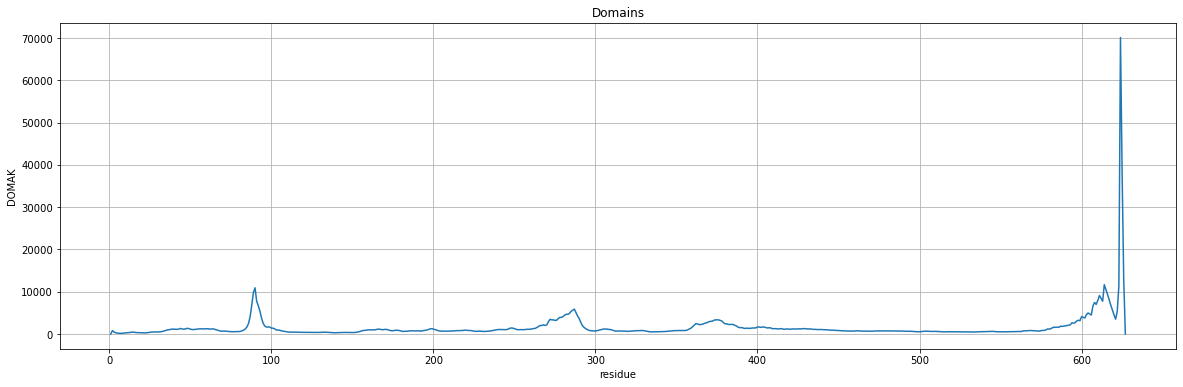

peaks: [ 89 286 613]


<Figure size 432x288 with 0 Axes>

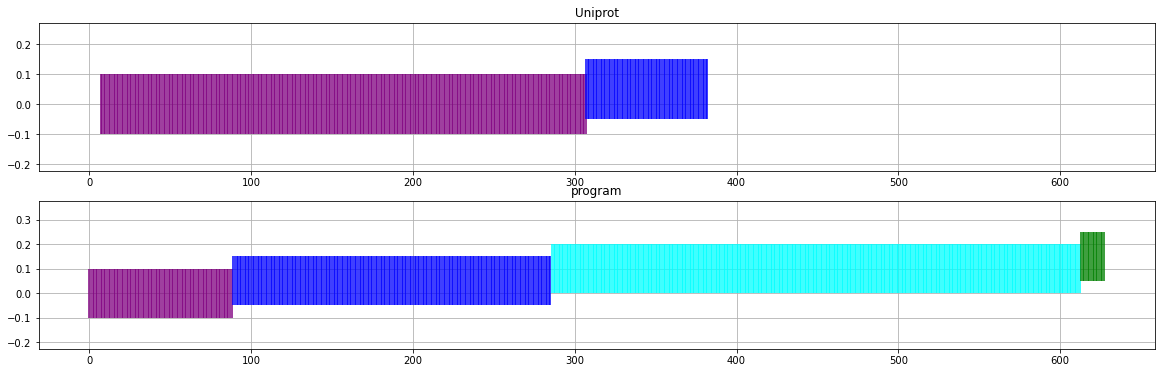

domains from UNIPROT: [range(7, 308), range(307, 383)]
domains calculated by the program: [range(0, 89), range(89, 286), range(286, 613), range(613, 628)]


In [6]:
main_program("6RSU.pdb", "Q9UHD2.txt")